# Manual contributor

This notebook extracts contribution tree data that has been exported manually
(copy-pasted) from openLCA into an Excel file, in the format shown in the
picture below.

<img src="manual_excel_example.png">

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

In [25]:
scenario = 'Baseline'

In [39]:
Baseline = pd.read_excel('..\Baseline_contributions.xlsx', 'CC').dropna()

In [40]:
for i,row in Baseline.iterrows():
    if row['Process'] == 'Process':
        Baseline.drop(i, axis=0, inplace=True)
    if row['Process'].startswith(scenario):
        sub = ' '.join(row['Process'].split(' ')[3:][:-2])
    Baseline.loc[i, 'Sub-process'] = sub

Baseline.reset_index(drop=True, inplace=True)
Baseline

,Contribution [%],Process,Required amount,Unit,Total result [kg CO2-Eq],Direct contribution [kg CO2-Eq],Sub-process
0,100,Baseline - 7 Effluent treatment - RER,1000,kg,-6332.301522,0,Effluent treatment
1,2.36,"market for quicklime, milled, packed | quickli...",124.492587,kg,149.154022,149.154022,Effluent treatment
2,2.34,"market for hazardous waste, for underground de...",641.504971,kg,148.232269,148.232269,Effluent treatment
3,2.31,"market group for electricity, medium voltage |...",1616.134777,MJ,146.061901,146.061901,Effluent treatment
4,0.0223,"market for wastewater, average | wastewater, a...",3.67375,m3,1.410856,1.410856,Effluent treatment
...,...,...,...,...,...,...,...
57,NaN,NaN,NaN,NaN,NaN,NaN,Li recovery
58,NaN,NaN,NaN,NaN,NaN,NaN,Ni recovery
59,NaN,NaN,NaN,NaN,NaN,NaN,Co recovery
60,NaN,NaN,NaN,NaN,NaN,NaN,Mn recovery


In [41]:
pivot_df = Baseline.pivot(index='Sub-process', columns='Process', values=Baseline.columns[4]).fillna(0)
pivot_df

Process,NaN,Baseline - 1 Leaching - RER,Baseline - 2 Solution purification - RER,Baseline - 3 Mn recovery - RER,Baseline - 4 Co recovery - RER,Baseline - 5 Ni recovery - RER,Baseline - 6 Li recovery - RER,Baseline - 7 Effluent treatment - RER,Cyanex 272 production,D2EHPA production,...,"market for quicklime, milled, packed | quicklime, milled, packed | Cutoff, S - RER","market for soda ash, dense | soda ash, dense | Cutoff, S - GLO","market for sodium hydroxide, without water, in 50% solution state | sodium hydroxide, without water, in 50% solution state | Cutoff, S - RER","market for sodium sulfate, anhydrite | sodium sulfate, anhydrite | Cutoff, S - RER","market for steam, in chemical industry | steam, in chemical industry | Cutoff, S - RER","market for sulfuric acid | sulfuric acid | Cutoff, S - RER","market for wastewater, average | wastewater, average | Cutoff, S - Europe without Switzerland","market for wastewater, unpolluted | wastewater, unpolluted | Cutoff, S - RoW","market group for electricity, medium voltage | electricity, medium voltage | Cutoff, S - RER","market group for tap water | tap water | Cutoff, S - RER"
Sub-process,,,,,,,,,,,,,,,,,,,,,
Co recovery,0,0.000000,0.00000,0.000000,-1613.633468,0.000000,0.00000,0.000000,170.266776,0.000000,...,0.000000,0.000000,111.475031,0.000000,57.340437,19.784404,0.000000,0.000000,56.762415,0.239813
Effluent treatment,0,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,-6332.301522,0.000000,0.000000,...,149.154022,0.000000,0.000000,0.000000,0.000000,0.000000,1.410856,1.301057,146.061901,0.440533
Leaching,0,723.289222,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,126.408178,0.000000,0.000000,35.610501,1.301850
Li recovery,0,0.000000,0.00000,0.000000,0.000000,0.000000,-6778.90216,0.000000,0.000000,0.000000,...,0.000000,1653.243782,0.000000,-913.523556,0.000000,0.000000,0.000000,0.000000,156.360179,0.535891
Mn recovery,0,0.000000,0.00000,1986.502433,0.000000,0.000000,0.00000,0.000000,0.000000,623.678259,...,0.000000,0.000000,17.770970,0.000000,101.004317,18.693489,0.000000,0.000000,65.943065,0.178626
Ni recovery,0,0.000000,0.00000,0.000000,0.000000,-6289.872331,0.00000,0.000000,0.000000,1078.695398,...,0.000000,0.000000,123.176781,0.000000,121.923798,60.798242,0.000000,0.000000,44.336631,0.497156
Solution purification,0,0.000000,1083.22255,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,150.769527,0.000000,0.000000,0.000000,0.000000,0.000000,105.838200,0.284609


In [42]:
# Define the colormap
positive_colors = mpl.colormaps['Oranges_r'].resampled(148)
negative_colors = mpl.colormaps['Blues'].resampled(108)

new_colors = np.vstack((
    positive_colors(np.linspace(0, 1, 158)),
    negative_colors(np.linspace(0, 1, 98))
))

# my_cmap = mpl.colors.ListedColormap(new_colors)
my_cmap = mpl.colormaps['tab20b']

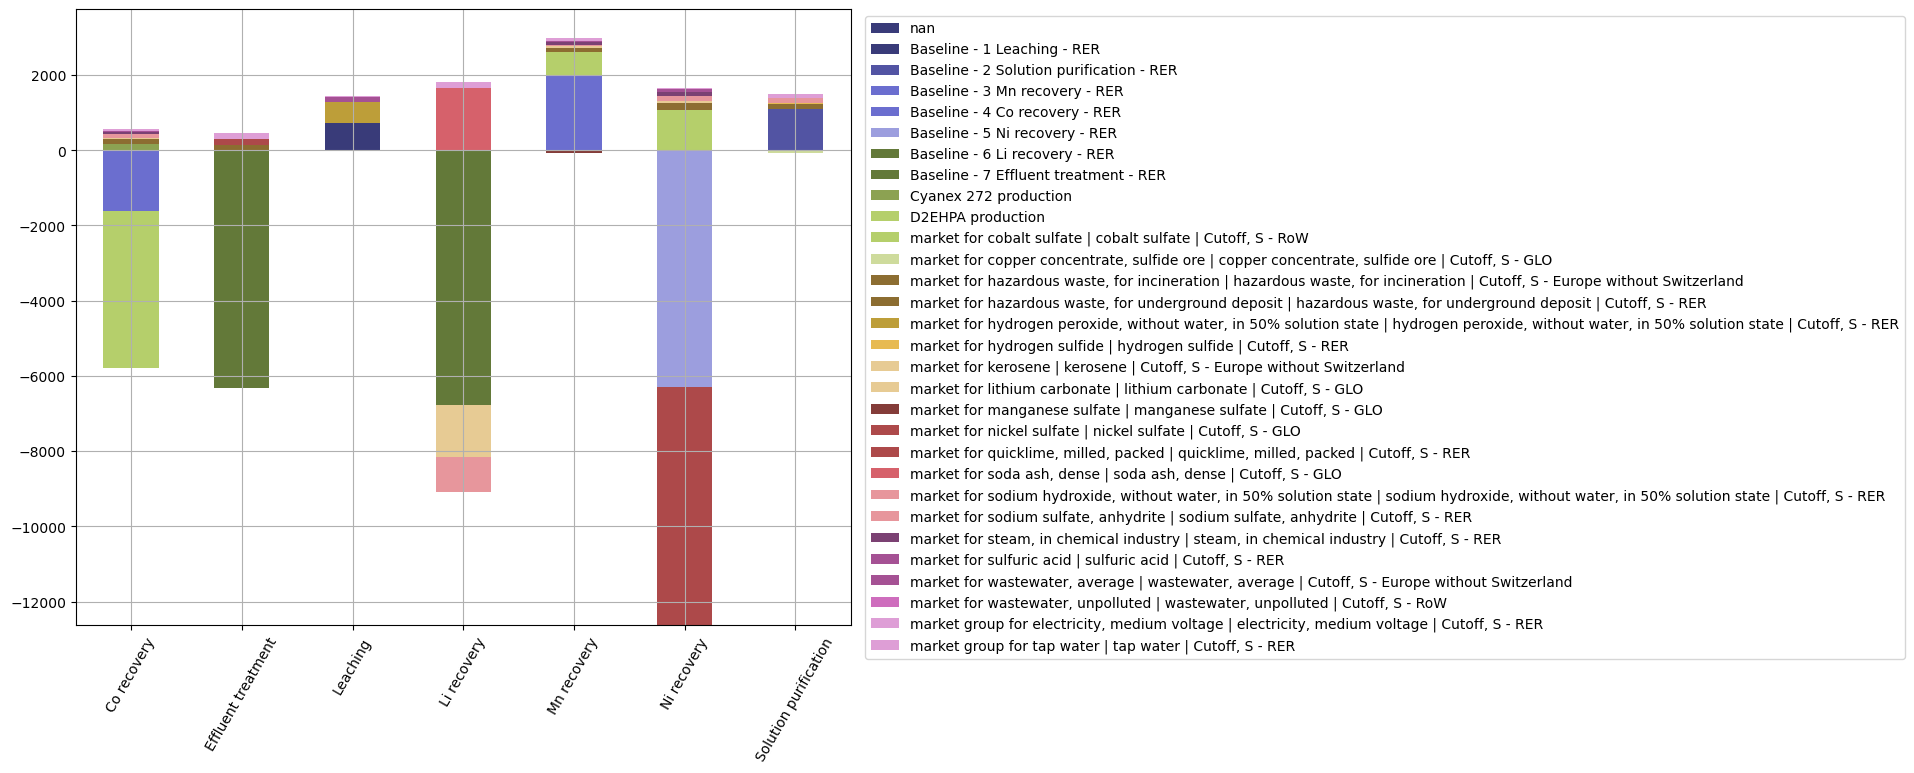

In [43]:
fig, ax = plt.subplots(figsize=(10, 8))

pivot_df.plot.bar(stacked=True, grid=True, ax=ax, cmap=my_cmap)
plt.legend(bbox_to_anchor=(1.01, 1.0))
plt.xlabel('')
plt.xticks(rotation=60)
# plt.ylabel(category)
mpl.rcParams.update({'font.size': 16})

plt.show()